In [70]:
import os
import pickle
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
from keras import backend as K
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression


# just some convenience functions here ...

def r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))


def metrics(y_true, y_pred, names):
    functions = dict(
        mse=sklearn.metrics.mean_squared_error,
        r2=sklearn.metrics.r2_score
    )
    return {n: functions[n](y_true, y_pred).round(4) for n in names}


def callbacks(args: dict, verbose: int):
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        patience=100, factor=0.5, verbose=verbose, min_lr=1e-5, **args
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=500, restore_best_weights=True, **args
    )

    return lr_schedule, early_stopping


# we set seeds for reproducibility. in practice, a model that works with one
# seed but not with another is a poor and unstable model.
pd.set_option('display.max_columns', None)
tf.random.set_seed(42)
np.random.seed(42)

# Introduction to Artificial Intelligence - Fall 2022

# Submission instructions
**Upload the files only. Do not zip them. Do not rename the files. The submission
should contain exactly one notebook and exactly one PDF file. Nothing else.
It is not necessary to upload data etc**.

# Exercise 02 - Classification and Regression
In this exercise, we will take a closer look at regression and classification
through the lens of classical models as well as neural networks in the form
of multi-layer perceptrons. We shall see how we can use machine learning
methods to reason about what information data contains and how we can use it
to make predictions about real-world phenomena.

# Task 2.0 - Introduction and Feature Engineering
In this part, we are going to work with a dataset containing house prices
published on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
Once extracted, you can find the data
description [here](house-prices/data_description.txt).

In [71]:
house_prices_pkl = os.path.abspath("house-prices.pkl")
if not os.path.exists(house_prices_pkl):
    with zipfile.ZipFile("house-prices.zip", "r") as zip_ref:
        zip_ref.extractall(os.getcwd())

    data = pd.read_csv(os.path.join("house-prices", "train.csv"))
    data = data.drop("Id", axis=1)

    with open(house_prices_pkl, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
with open(house_prices_pkl, "rb") as f:
    data = pickle.load(f)

When working with new data, it is always a good idea to get a rough
impression of what it represents. The data contains a large number of
features and for simplicity, we will work with a subset of numerical
features only.

In [73]:
print(data.head(3))

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFac

We have a long list of features and values. Yet, it is unclear how we
would select features in a meaningful way. In the end, we would like to
have features which are able to describe the price of a house well.
We do not get any insight about how well any of these features could (or not)
be used to build a predictive model. Therefore, we need to obtain a more
condensed view of the data. One simple and efficient way to do this is to
look at correlations in the data. We would like to select features which
"move with the price", i.e., they somehow correlate. Note that we use the
absolute values of correlation coefficients since we are more interested
in how strong those values move together and less in their direction.
A good machine learning model will account for this by tuning the parameters
accordingly. You can remove the `.abs()` call if you are interested in
how the plot would look otherwise.

/var/folders/qy/xtyl7w890r35n_4frd42d22m0000gn/T/ipykernel_4200/3140129569.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr().abs(), cmap="Blues")


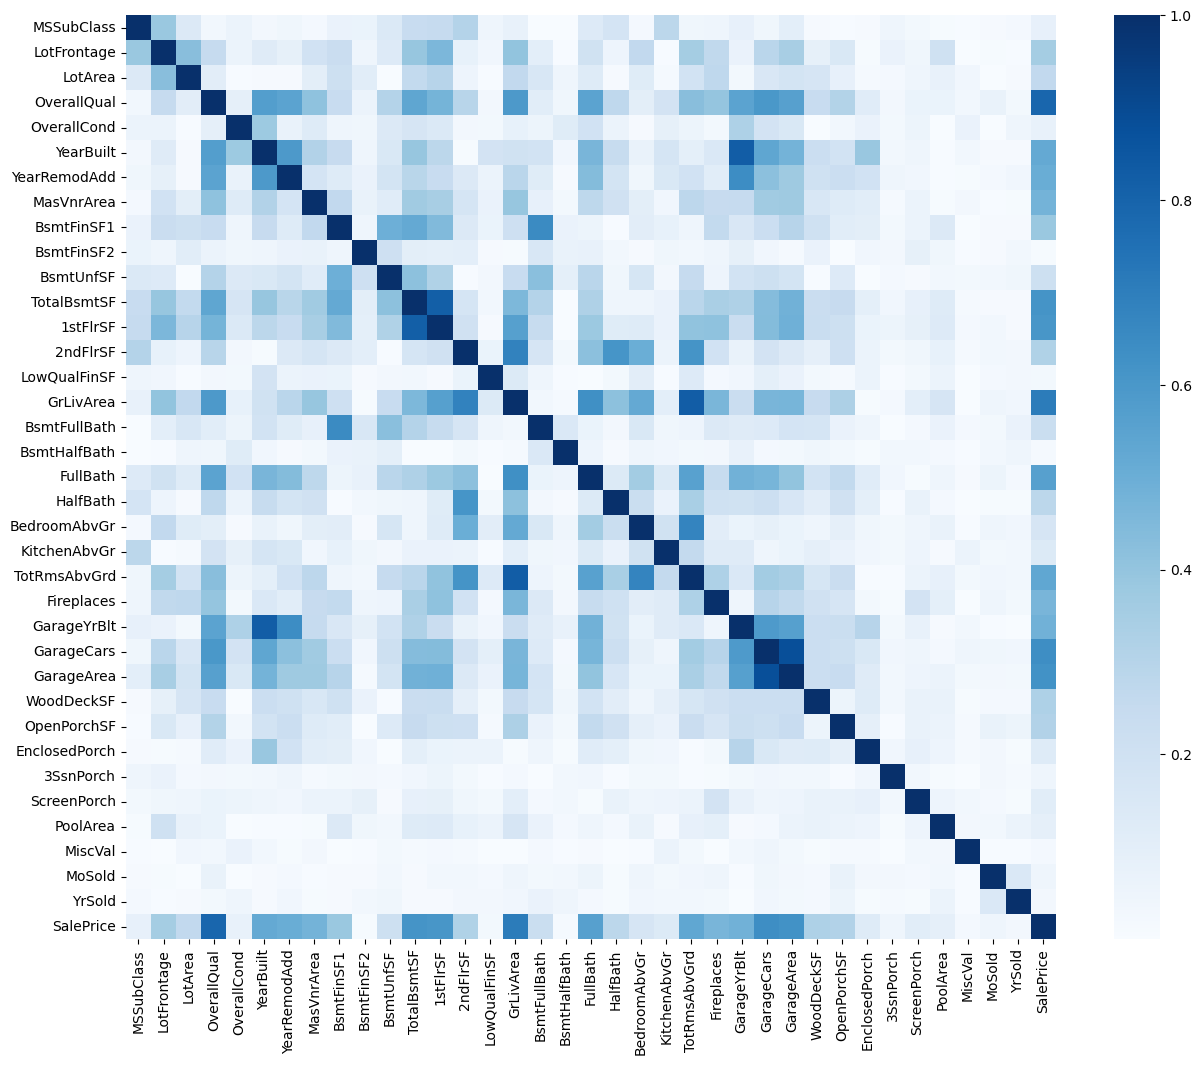

In [74]:
pyplot.figure(figsize=(15, 12))
sns.heatmap(data.corr().abs(), cmap="Blues")
pyplot.show()

There are two types of information we can read off from this plot.

First, we can easily identify the set of features which seem to be related
to the house price. We can see that features like overall quality or a large
garage seem to have a strong effect on the price. This kind of reasoning
makes sense intuitively and is likely correct in this case, but not
[in general](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation).
This step allows us to reduce the larger set of features to a smaller set
of features which we believe to be meaningful.

Second, we can use inter-feature correlation to further reduce this set.
For example, `GarageCars` and `GarageArea` both have a high correlation
with `SalePrice`. While these features are descriptive, they are not
independent. Under regular circumstances, people put cars into a garage,
and a larger garage simply can fit more cars. This does not add any
meaningful information for the model. `GarageArea` would be the preferred
feature in this situation, since a 4-car garage may or may not be twice
as large as a 2-car garage, while a 400m² garage is twice as large as a
200m² garage for sure.
In the end, they are all just numbers for us humans. We can think of them
on a higher level and in a context. A computer cannot. Thus, it is always
important to remember that there are different
["types"](https://en.wikipedia.org/wiki/Level_of_measurement) of numbers.
In practice, this kind of precision is not always necessary, but it is
important to be aware of these situations in cases where the model fails.
We should now have a better feeling for what's inside our dataset.
to learn anything useful.

We call the above process **feature engineering**. It's always necessary
to do it in one form or the other. Now that we went through it, it's time
to see what we can do with it.

# Task 2.1 - Regression
In this task, we will gradually move from simple regression techniques
to arbitrarily complex neural networks (complexity measured by model size
rather than complexity in their architecture). We first process our data
a bit further and select a small set of features which we think serve as
a good set for prediction.

In [75]:
x_fields_num = ["OverallQual", "1stFlrSF", "2ndFlrSF"]
x_fields_cat = ["Neighborhood"]

y_fields = ["SalePrice"]

n_train = int(len(data) * 0.8)

x_data = data[x_fields_num + x_fields_cat]
y_data = data[y_fields]

x_data = x_data.fillna(-1)
x_data = pd.get_dummies(x_data, columns=x_fields_cat).astype(float)

x_train, x_test = x_data[:n_train], x_data[n_train:]
y_train, y_test = y_data[:n_train], y_data[n_train:]

Now, let's look at correlations once again with our encoded data.

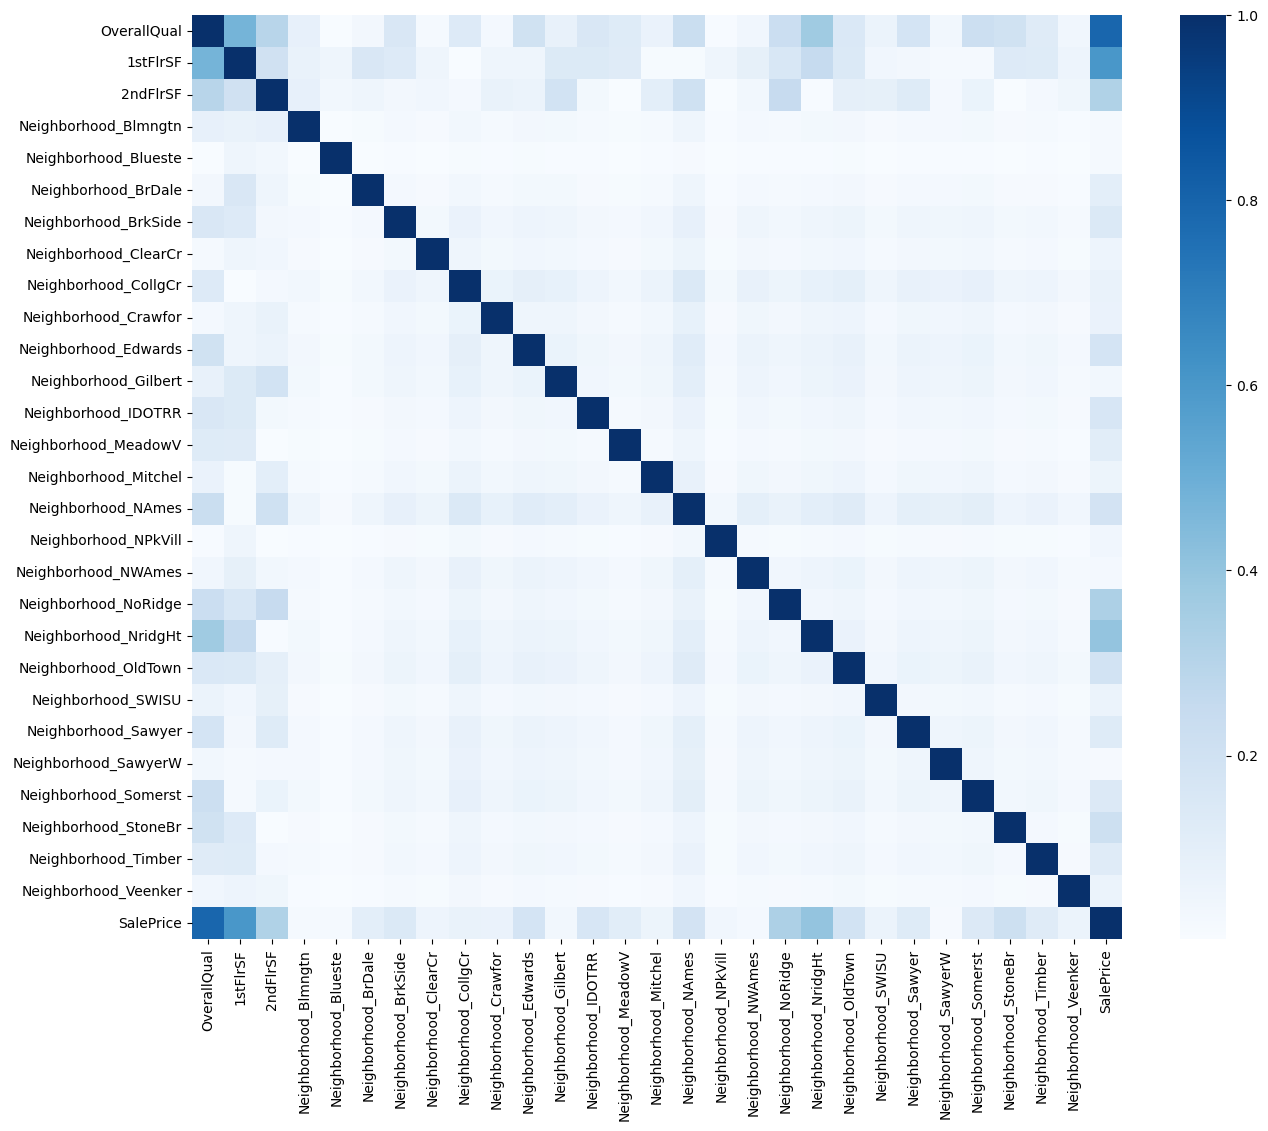

In [76]:
pyplot.figure(figsize=(15, 12))
sns.heatmap(pd.concat([x_data, y_data], axis=1).corr().abs(), cmap="Blues")
pyplot.show()

We start with a simple linear regression model using scikit's
[Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
model. Train the model using the training data first. After fitting, analyze
the model parameters. You should find all relevant information in the docs.

In [77]:
lr = LinearRegression()
# fit the model
lr.fit(x_train, y_train)

print(f"Coefficients: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")


Coefficients: [[ 1.79977957e+04  8.66128012e+01  5.26823407e+01 -1.31422924e+04
  -1.93107586e+04 -3.09948860e+04 -1.26303243e+04  1.62324405e+04
   7.71419336e+03  1.03122753e+03 -2.31650427e+04  1.97587883e+03
  -2.68144778e+04 -1.60349360e+04 -7.96236484e+03 -1.25408670e+04
  -1.69875658e+04 -1.39187447e+04  4.95681566e+04  6.00774088e+04
  -3.01367413e+04 -2.97036051e+04 -8.27635556e+03 -6.04838342e+03
   1.93210733e+04  5.97164808e+04  1.85012807e+04  3.35292049e+04]]
Intercept: [-46200.77386141]


How many parameters does the linear regression model have?
According to the model, which of the features is the most influential one?
Use the column name as found in the dataframe.

In [78]:
lr_number_of_parameters = lr.n_features_in_
lr_most_influential_feature = None

# Get the index of the most influential feature
most_influential_feature_index = lr.coef_.argmax()
lr_most_influential_feature = x_data.columns[most_influential_feature_index]
print(f"Most influential feature: {lr_most_influential_feature}")



Most influential feature: Neighborhood_NridgHt


In [79]:
assert getattr(lr, "coef_") is not None, "model is not trained"

For very simple models like linear regression, we are able to reason about
their parameters and how they are related to the modelled quantity. This does
not tell us anything about the model's quality, though. There are several
ways to analyze a model's quality.

In [80]:
print(metrics(y_train, lr.predict(x_train), names=["mse", "r2"]))
print(metrics(y_test, lr.predict(x_test), names=["mse", "r2"]))

{'mse': 1134382692.8914, 'r2': 0.8172}
{'mse': 1883404489.1577, 'r2': 0.7191}


We use MeanSquaredError (MSE) frequently as an optimization criterion. Since
we did not normalize the target price, we cannot directly read off how good
our model performs using MSE. Thus, it is common to introduce other statistics
to measure model performance. For regression tasks, a frequent choice is
the [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) score.
$R^2$ lies in $[-\infty, 1]$. A score of $0$ indicates that the model predicts
the mean value only, thus, a score greater $0$ indicates that the model learned
$something$. In the above case, our score is ~$0.7$ which is not too bad but
also with a large potential for improvement. Let's see how accurate a neural
network model gets.

In the cell below, implement a method that builds a neural network using
`BatchNormalization` and `Dense` layers. The resulting architecture should be
the following sequence:
- `Input`,
- `BatchNorm_0`, `Dense_0`, `Activation_0`,
-  ...
- `BatchNorm_n`, `Dense_n`, `Activation_n`,
- `Dense_out`, `Activation_out`
Note that `Dense` layers accept an `activation` parameter. Alternatively,
you can use activation layers as long as the resulting architecture performs
the same computations.

In [81]:
from tensorflow.keras.layers import BatchNormalization, Dense, Activation

def multi_layer_perceptron(
        hidden_units: list[int], hidden_activation: str,
        output_units: int, output_activation: str
):
    layers = []
    
    # Add input layer
    layers.append(BatchNormalization())
    
    # Add hidden layers
    for i, units in enumerate(hidden_units):
        layers.append(Dense(units, activation = hidden_activation))
        layers.append(BatchNormalization())
        
     # Add output layer
    layers.append(Dense(output_units, activation = output_activation))    
    
    model = tf.keras.Sequential(layers)
    return model

Below, configure your multi-layer perceptron and run the training.
Try out a few different configurations, i.e., vary model width and depth as
well as the activation functions. Your objective is to find a configuration
of your model such that it achieves an $R^2$ score **greater than 0.8**.

Please do not add or remove any arguments of the `multi_layer_perceptron` function.

In [82]:
mlp = multi_layer_perceptron(
    hidden_units = [64, 128], hidden_activation = 'relu',
    output_units = 1, output_activation = 'linear'
)

The settings below are common training utilities to improve the convergence
of neural networks as well as their training time by stopping training
when there is no considerable improvement anymore. Early stopping also helps
to prevent overfitting. Do not modify any of these settings for submission
as it may cause training to behave differently.

In [83]:
callback_args = dict(monitor="val_r2", mode="max", min_delta=0.005)
lr_schedule, early_stopping = callbacks(callback_args, verbose=1)

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[r2]
)

In [84]:
print("training model")
mlp.fit(
    x_train, y_train,
    validation_split=0.2,
    callbacks=[lr_schedule, early_stopping],
    epochs=2500, batch_size=64, verbose=1
)

training model
Epoch 1/2500
15/15 [==============================] - 1s 10ms/step - loss: 40007692288.0000 - r2: -5.9294 - val_loss: 34073540608.0000 - val_r2: -7.0019 - lr: 0.0010
Epoch 2/2500
15/15 [==============================] - 0s 2ms/step - loss: 40006987776.0000 - r2: -5.5256 - val_loss: 34072348672.0000 - val_r2: -7.0016 - lr: 0.0010
Epoch 3/2500
15/15 [==============================] - 0s 3ms/step - loss: 40006316032.0000 - r2: -5.4534 - val_loss: 34071066624.0000 - val_r2: -7.0013 - lr: 0.0010
Epoch 4/2500
15/15 [==============================] - 0s 3ms/step - loss: 40005623808.0000 - r2: -5.5133 - val_loss: 34069721088.0000 - val_r2: -7.0010 - lr: 0.0010
Epoch 5/2500
15/15 [==============================] - 0s 3ms/step - loss: 40004898816.0000 - r2: -5.6159 - val_loss: 34068424704.0000 - val_r2: -7.0007 - lr: 0.0010
Epoch 6/2500
15/15 [==============================] - 0s 3ms/step - loss: 40004173824.0000 - r2: -5.7143 - val_loss: 34067357696.0000 - val_r2: -7.0004 - lr: 0

15/15 [==============================] - 0s 2ms/step - loss: 39904645120.0000 - r2: -5.7434 - val_loss: 34017570816.0000 - val_r2: -6.9902 - lr: 0.0010
Epoch 51/2500
15/15 [==============================] - 0s 2ms/step - loss: 39900938240.0000 - r2: -5.6166 - val_loss: 34015803392.0000 - val_r2: -6.9897 - lr: 0.0010
Epoch 52/2500
15/15 [==============================] - 0s 2ms/step - loss: 39896309760.0000 - r2: -5.4327 - val_loss: 34014971904.0000 - val_r2: -6.9896 - lr: 0.0010
Epoch 53/2500
15/15 [==============================] - 0s 2ms/step - loss: 39891972096.0000 - r2: -5.2774 - val_loss: 34014398464.0000 - val_r2: -6.9895 - lr: 0.0010
Epoch 54/2500
15/15 [==============================] - 0s 2ms/step - loss: 39888523264.0000 - r2: -5.3626 - val_loss: 34012897280.0000 - val_r2: -6.9893 - lr: 0.0010
Epoch 55/2500
15/15 [==============================] - 0s 2ms/step - loss: 39884849152.0000 - r2: -5.6388 - val_loss: 34011795456.0000 - val_r2: -6.9890 - lr: 0.0010
Epoch 56/2500
15/1

15/15 [==============================] - 0s 2ms/step - loss: 39648681984.0000 - r2: -5.5086 - val_loss: 33825165312.0000 - val_r2: -6.9472 - lr: 0.0010
Epoch 100/2500
15/15 [==============================] - 0s 2ms/step - loss: 39642083328.0000 - r2: -5.4671 - val_loss: 33822246912.0000 - val_r2: -6.9468 - lr: 0.0010
Epoch 101/2500
15/15 [==============================] - 0s 2ms/step - loss: 39636865024.0000 - r2: -5.8271 - val_loss: 33802944512.0000 - val_r2: -6.9423 - lr: 0.0010
Epoch 102/2500
15/15 [==============================] - 0s 2ms/step - loss: 39628574720.0000 - r2: -5.4688 - val_loss: 33793368064.0000 - val_r2: -6.9400 - lr: 0.0010
Epoch 103/2500
15/15 [==============================] - 0s 2ms/step - loss: 39620755456.0000 - r2: -5.3570 - val_loss: 33799284736.0000 - val_r2: -6.9414 - lr: 0.0010
Epoch 104/2500
15/15 [==============================] - 0s 2ms/step - loss: 39614279680.0000 - r2: -5.2491 - val_loss: 33801433088.0000 - val_r2: -6.9420 - lr: 0.0010
Epoch 105/250

15/15 [==============================] - 0s 2ms/step - loss: 39270215680.0000 - r2: -5.5706 - val_loss: 33566261248.0000 - val_r2: -6.8901 - lr: 0.0010
Epoch 149/2500
15/15 [==============================] - 0s 2ms/step - loss: 39261114368.0000 - r2: -5.6052 - val_loss: 33546635264.0000 - val_r2: -6.8858 - lr: 0.0010
Epoch 150/2500
15/15 [==============================] - 0s 2ms/step - loss: 39249305600.0000 - r2: -5.1773 - val_loss: 33542072320.0000 - val_r2: -6.8848 - lr: 0.0010
Epoch 151/2500
15/15 [==============================] - 0s 2ms/step - loss: 39240925184.0000 - r2: -5.6502 - val_loss: 33555148800.0000 - val_r2: -6.8874 - lr: 0.0010
Epoch 152/2500
15/15 [==============================] - 0s 2ms/step - loss: 39231369216.0000 - r2: -5.4130 - val_loss: 33558122496.0000 - val_r2: -6.8878 - lr: 0.0010
Epoch 153/2500
15/15 [==============================] - 0s 2ms/step - loss: 39222968320.0000 - r2: -5.3548 - val_loss: 33568182272.0000 - val_r2: -6.8906 - lr: 0.0010
Epoch 154/250

15/15 [==============================] - 0s 2ms/step - loss: 38790619136.0000 - r2: -5.7425 - val_loss: 33131388928.0000 - val_r2: -6.7924 - lr: 0.0010
Epoch 198/2500
15/15 [==============================] - 0s 2ms/step - loss: 38770634752.0000 - r2: -5.2945 - val_loss: 33165606912.0000 - val_r2: -6.8003 - lr: 0.0010
Epoch 199/2500
15/15 [==============================] - 0s 2ms/step - loss: 38763102208.0000 - r2: -5.3502 - val_loss: 33214629888.0000 - val_r2: -6.8120 - lr: 0.0010
Epoch 200/2500
15/15 [==============================] - 0s 2ms/step - loss: 38751039488.0000 - r2: -5.3771 - val_loss: 33211590656.0000 - val_r2: -6.8115 - lr: 0.0010
Epoch 201/2500
15/15 [==============================] - 0s 2ms/step - loss: 38744059904.0000 - r2: -5.4626 - val_loss: 33203554304.0000 - val_r2: -6.8099 - lr: 0.0010
Epoch 202/2500
15/15 [==============================] - 0s 2ms/step - loss: 38726508544.0000 - r2: -5.2140 - val_loss: 33176961024.0000 - val_r2: -6.8039 - lr: 0.0010
Epoch 203/250

15/15 [==============================] - 0s 2ms/step - loss: 38223138816.0000 - r2: -5.4378 - val_loss: 32728369152.0000 - val_r2: -6.7019 - lr: 0.0010
Epoch 247/2500
15/15 [==============================] - 0s 2ms/step - loss: 38213996544.0000 - r2: -5.4823 - val_loss: 32706891776.0000 - val_r2: -6.6973 - lr: 0.0010
Epoch 248/2500
15/15 [==============================] - 0s 2ms/step - loss: 38192599040.0000 - r2: -5.2426 - val_loss: 32704456704.0000 - val_r2: -6.6982 - lr: 0.0010
Epoch 249/2500
15/15 [==============================] - 0s 2ms/step - loss: 38178541568.0000 - r2: -5.5441 - val_loss: 32726956032.0000 - val_r2: -6.7034 - lr: 0.0010
Epoch 250/2500
15/15 [==============================] - 0s 2ms/step - loss: 38167080960.0000 - r2: -5.3637 - val_loss: 32686696448.0000 - val_r2: -6.6936 - lr: 0.0010
Epoch 251/2500
15/15 [==============================] - 0s 2ms/step - loss: 38151376896.0000 - r2: -5.1458 - val_loss: 32666404864.0000 - val_r2: -6.6891 - lr: 0.0010
Epoch 252/250

15/15 [==============================] - 0s 2ms/step - loss: 37573001216.0000 - r2: -5.1821 - val_loss: 32150640640.0000 - val_r2: -6.5725 - lr: 0.0010
Epoch 296/2500
15/15 [==============================] - 0s 2ms/step - loss: 37557596160.0000 - r2: -5.2004 - val_loss: 32164077568.0000 - val_r2: -6.5758 - lr: 0.0010
Epoch 297/2500
15/15 [==============================] - 0s 2ms/step - loss: 37534515200.0000 - r2: -4.9646 - val_loss: 32155729920.0000 - val_r2: -6.5727 - lr: 0.0010
Epoch 298/2500
15/15 [==============================] - 0s 2ms/step - loss: 37521850368.0000 - r2: -5.1830 - val_loss: 32175058944.0000 - val_r2: -6.5778 - lr: 0.0010
Epoch 299/2500
15/15 [==============================] - 0s 2ms/step - loss: 37525708800.0000 - r2: -5.6774 - val_loss: 32179726336.0000 - val_r2: -6.5792 - lr: 0.0010
Epoch 300/2500
15/15 [==============================] - 0s 2ms/step - loss: 37501874176.0000 - r2: -5.2818 - val_loss: 32161861632.0000 - val_r2: -6.5740 - lr: 0.0010
Epoch 301/250

15/15 [==============================] - 0s 2ms/step - loss: 36840079360.0000 - r2: -4.8856 - val_loss: 31645841408.0000 - val_r2: -6.4606 - lr: 0.0010
Epoch 345/2500
15/15 [==============================] - 0s 2ms/step - loss: 36846129152.0000 - r2: -5.2766 - val_loss: 31584983040.0000 - val_r2: -6.4464 - lr: 0.0010
Epoch 346/2500
15/15 [==============================] - 0s 2ms/step - loss: 36828954624.0000 - r2: -5.0460 - val_loss: 31621173248.0000 - val_r2: -6.4551 - lr: 0.0010
Epoch 347/2500
15/15 [==============================] - 0s 2ms/step - loss: 36817768448.0000 - r2: -5.2608 - val_loss: 31545024512.0000 - val_r2: -6.4361 - lr: 0.0010
Epoch 348/2500
15/15 [==============================] - 0s 2ms/step - loss: 36793913344.0000 - r2: -5.0063 - val_loss: 31584090112.0000 - val_r2: -6.4441 - lr: 0.0010
Epoch 349/2500
15/15 [==============================] - 0s 2ms/step - loss: 36778176512.0000 - r2: -5.1095 - val_loss: 31634198528.0000 - val_r2: -6.4592 - lr: 0.0010
Epoch 350/250

15/15 [==============================] - 0s 2ms/step - loss: 36083613696.0000 - r2: -5.0341 - val_loss: 30774853632.0000 - val_r2: -6.2591 - lr: 0.0010
Epoch 394/2500
15/15 [==============================] - 0s 2ms/step - loss: 36063326208.0000 - r2: -4.9726 - val_loss: 30848120832.0000 - val_r2: -6.2775 - lr: 0.0010
Epoch 395/2500
15/15 [==============================] - 0s 2ms/step - loss: 36048232448.0000 - r2: -4.9726 - val_loss: 30867951616.0000 - val_r2: -6.2819 - lr: 0.0010
Epoch 396/2500
15/15 [==============================] - 0s 2ms/step - loss: 36020891648.0000 - r2: -4.8150 - val_loss: 30894446592.0000 - val_r2: -6.2891 - lr: 0.0010
Epoch 397/2500
15/15 [==============================] - 0s 2ms/step - loss: 36027809792.0000 - r2: -5.2021 - val_loss: 30833162240.0000 - val_r2: -6.2748 - lr: 0.0010
Epoch 398/2500
15/15 [==============================] - 0s 2ms/step - loss: 35987939328.0000 - r2: -4.9298 - val_loss: 30859528192.0000 - val_r2: -6.2801 - lr: 0.0010
Epoch 399/250

15/15 [==============================] - 0s 3ms/step - loss: 35232706560.0000 - r2: -4.7581 - val_loss: 30163861504.0000 - val_r2: -6.1224 - lr: 0.0010
Epoch 443/2500
15/15 [==============================] - 0s 2ms/step - loss: 35211931648.0000 - r2: -4.7930 - val_loss: 30219544576.0000 - val_r2: -6.1343 - lr: 0.0010
Epoch 444/2500
15/15 [==============================] - 0s 2ms/step - loss: 35175964672.0000 - r2: -4.4859 - val_loss: 30220963840.0000 - val_r2: -6.1348 - lr: 0.0010
Epoch 445/2500
15/15 [==============================] - 0s 2ms/step - loss: 35163299840.0000 - r2: -4.7424 - val_loss: 30279241728.0000 - val_r2: -6.1510 - lr: 0.0010
Epoch 446/2500
15/15 [==============================] - 0s 2ms/step - loss: 35180343296.0000 - r2: -4.9444 - val_loss: 30372433920.0000 - val_r2: -6.1723 - lr: 0.0010
Epoch 447/2500
15/15 [==============================] - 0s 2ms/step - loss: 35132006400.0000 - r2: -4.7111 - val_loss: 30373058560.0000 - val_r2: -6.1721 - lr: 0.0010
Epoch 448/250

15/15 [==============================] - 0s 2ms/step - loss: 34333335552.0000 - r2: -4.6012 - val_loss: 29336162304.0000 - val_r2: -5.9342 - lr: 0.0010
Epoch 492/2500
15/15 [==============================] - 0s 2ms/step - loss: 34326925312.0000 - r2: -4.7676 - val_loss: 29374517248.0000 - val_r2: -5.9416 - lr: 0.0010
Epoch 493/2500
15/15 [==============================] - 0s 2ms/step - loss: 34309974016.0000 - r2: -4.8369 - val_loss: 29351897088.0000 - val_r2: -5.9351 - lr: 0.0010
Epoch 494/2500
15/15 [==============================] - 0s 2ms/step - loss: 34285471744.0000 - r2: -4.7237 - val_loss: 29381257216.0000 - val_r2: -5.9448 - lr: 0.0010
Epoch 495/2500
15/15 [==============================] - 0s 2ms/step - loss: 34269313024.0000 - r2: -4.7085 - val_loss: 29447804928.0000 - val_r2: -5.9667 - lr: 0.0010
Epoch 496/2500
15/15 [==============================] - 0s 2ms/step - loss: 34235658240.0000 - r2: -4.5831 - val_loss: 29398005760.0000 - val_r2: -5.9514 - lr: 0.0010
Epoch 497/250

15/15 [==============================] - 0s 2ms/step - loss: 33411518464.0000 - r2: -4.6940 - val_loss: 28627443712.0000 - val_r2: -5.7694 - lr: 0.0010
Epoch 541/2500
15/15 [==============================] - 0s 2ms/step - loss: 33406464000.0000 - r2: -4.7905 - val_loss: 28637085696.0000 - val_r2: -5.7743 - lr: 0.0010
Epoch 542/2500
15/15 [==============================] - 0s 2ms/step - loss: 33352712192.0000 - r2: -4.4683 - val_loss: 28554776576.0000 - val_r2: -5.7535 - lr: 0.0010
Epoch 543/2500
15/15 [==============================] - 0s 2ms/step - loss: 33329537024.0000 - r2: -4.5036 - val_loss: 28613941248.0000 - val_r2: -5.7713 - lr: 0.0010
Epoch 544/2500
15/15 [==============================] - 0s 2ms/step - loss: 33293256704.0000 - r2: -4.5287 - val_loss: 28752527360.0000 - val_r2: -5.8055 - lr: 0.0010
Epoch 545/2500
15/15 [==============================] - 0s 2ms/step - loss: 33284478976.0000 - r2: -4.3349 - val_loss: 28673355776.0000 - val_r2: -5.7854 - lr: 0.0010
Epoch 546/250

15/15 [==============================] - 0s 2ms/step - loss: 32415268864.0000 - r2: -4.5046 - val_loss: 27757078528.0000 - val_r2: -5.5760 - lr: 0.0010
Epoch 590/2500
15/15 [==============================] - 0s 2ms/step - loss: 32376600576.0000 - r2: -4.3122 - val_loss: 27980326912.0000 - val_r2: -5.6264 - lr: 0.0010
Epoch 591/2500
15/15 [==============================] - 0s 2ms/step - loss: 32343390208.0000 - r2: -4.3794 - val_loss: 28065495040.0000 - val_r2: -5.6513 - lr: 0.0010
Epoch 592/2500
15/15 [==============================] - 0s 2ms/step - loss: 32327553024.0000 - r2: -4.2827 - val_loss: 28063348736.0000 - val_r2: -5.6510 - lr: 0.0010
Epoch 593/2500
15/15 [==============================] - 0s 2ms/step - loss: 32290998272.0000 - r2: -4.1385 - val_loss: 28041543680.0000 - val_r2: -5.6411 - lr: 0.0010
Epoch 594/2500
15/15 [==============================] - 0s 2ms/step - loss: 32266727424.0000 - r2: -4.2409 - val_loss: 27952254976.0000 - val_r2: -5.6208 - lr: 0.0010
Epoch 595/250

15/15 [==============================] - 0s 2ms/step - loss: 31361873920.0000 - r2: -4.2134 - val_loss: 27489974272.0000 - val_r2: -5.5248 - lr: 0.0010
Epoch 639/2500
15/15 [==============================] - 0s 2ms/step - loss: 31325747200.0000 - r2: -4.0490 - val_loss: 27615533056.0000 - val_r2: -5.5513 - lr: 0.0010
Epoch 640/2500
15/15 [==============================] - 0s 2ms/step - loss: 31354673152.0000 - r2: -4.5407 - val_loss: 27590942720.0000 - val_r2: -5.5493 - lr: 0.0010
Epoch 641/2500
15/15 [==============================] - 0s 2ms/step - loss: 31282628608.0000 - r2: -4.0337 - val_loss: 27442249728.0000 - val_r2: -5.5142 - lr: 0.0010
Epoch 642/2500
15/15 [==============================] - 0s 2ms/step - loss: 31256551424.0000 - r2: -4.0687 - val_loss: 27333382144.0000 - val_r2: -5.4862 - lr: 0.0010
Epoch 643/2500
15/15 [==============================] - 0s 2ms/step - loss: 31261222912.0000 - r2: -4.1589 - val_loss: 27469697024.0000 - val_r2: -5.5244 - lr: 0.0010
Epoch 644/250

15/15 [==============================] - 0s 2ms/step - loss: 30293927936.0000 - r2: -4.0649 - val_loss: 26725083136.0000 - val_r2: -5.3596 - lr: 0.0010
Epoch 688/2500
15/15 [==============================] - 0s 2ms/step - loss: 30275049472.0000 - r2: -4.1012 - val_loss: 26567966720.0000 - val_r2: -5.3163 - lr: 0.0010
Epoch 689/2500
15/15 [==============================] - 0s 2ms/step - loss: 30233147392.0000 - r2: -3.9260 - val_loss: 26015016960.0000 - val_r2: -5.1807 - lr: 0.0010
Epoch 690/2500
15/15 [==============================] - 0s 2ms/step - loss: 30218952704.0000 - r2: -4.0505 - val_loss: 25911629824.0000 - val_r2: -5.1542 - lr: 0.0010
Epoch 691/2500
15/15 [==============================] - 0s 2ms/step - loss: 30158981120.0000 - r2: -3.7848 - val_loss: 25915385856.0000 - val_r2: -5.1553 - lr: 0.0010
Epoch 692/2500
15/15 [==============================] - 0s 2ms/step - loss: 30147321856.0000 - r2: -3.8391 - val_loss: 26252097536.0000 - val_r2: -5.2436 - lr: 0.0010
Epoch 693/250

15/15 [==============================] - 0s 2ms/step - loss: 29122920448.0000 - r2: -3.6069 - val_loss: 25270185984.0000 - val_r2: -5.0131 - lr: 0.0010
Epoch 737/2500
15/15 [==============================] - 0s 2ms/step - loss: 29146828800.0000 - r2: -3.7350 - val_loss: 25643339776.0000 - val_r2: -5.1007 - lr: 0.0010
Epoch 738/2500
15/15 [==============================] - 0s 2ms/step - loss: 29194082304.0000 - r2: -3.9884 - val_loss: 25447028736.0000 - val_r2: -5.0571 - lr: 0.0010
Epoch 739/2500
15/15 [==============================] - 0s 2ms/step - loss: 29106810880.0000 - r2: -3.7214 - val_loss: 25194475520.0000 - val_r2: -4.9943 - lr: 0.0010
Epoch 740/2500
15/15 [==============================] - 0s 2ms/step - loss: 29110675456.0000 - r2: -3.8372 - val_loss: 25233819648.0000 - val_r2: -5.0067 - lr: 0.0010
Epoch 741/2500
15/15 [==============================] - 0s 2ms/step - loss: 29075347456.0000 - r2: -3.8947 - val_loss: 25167497216.0000 - val_r2: -4.9926 - lr: 0.0010
Epoch 742/250

15/15 [==============================] - 0s 2ms/step - loss: 28094992384.0000 - r2: -3.7201 - val_loss: 24590518272.0000 - val_r2: -4.8627 - lr: 0.0010
Epoch 786/2500
15/15 [==============================] - 0s 2ms/step - loss: 28032806912.0000 - r2: -3.8306 - val_loss: 24311369728.0000 - val_r2: -4.7955 - lr: 0.0010
Epoch 787/2500
15/15 [==============================] - 0s 2ms/step - loss: 28025059328.0000 - r2: -3.6301 - val_loss: 24507338752.0000 - val_r2: -4.8385 - lr: 0.0010
Epoch 788/2500
15/15 [==============================] - 0s 2ms/step - loss: 27920285696.0000 - r2: -3.4106 - val_loss: 24764604416.0000 - val_r2: -4.8972 - lr: 0.0010
Epoch 789/2500
15/15 [==============================] - 0s 2ms/step - loss: 27916453888.0000 - r2: -3.5283 - val_loss: 24428470272.0000 - val_r2: -4.8225 - lr: 0.0010
Epoch 790/2500
15/15 [==============================] - 0s 2ms/step - loss: 27900616704.0000 - r2: -3.5570 - val_loss: 24548159488.0000 - val_r2: -4.8578 - lr: 0.0010
Epoch 791/250

15/15 [==============================] - 0s 2ms/step - loss: 26848149504.0000 - r2: -3.3108 - val_loss: 23741032448.0000 - val_r2: -4.6715 - lr: 0.0010
Epoch 835/2500
15/15 [==============================] - 0s 2ms/step - loss: 26873925632.0000 - r2: -3.4253 - val_loss: 24378025984.0000 - val_r2: -4.8262 - lr: 0.0010
Epoch 836/2500
15/15 [==============================] - 0s 2ms/step - loss: 26809108480.0000 - r2: -3.3444 - val_loss: 24613300224.0000 - val_r2: -4.8803 - lr: 0.0010
Epoch 837/2500
15/15 [==============================] - 0s 2ms/step - loss: 26872283136.0000 - r2: -3.5260 - val_loss: 24145082368.0000 - val_r2: -4.7711 - lr: 0.0010
Epoch 838/2500
15/15 [==============================] - 0s 2ms/step - loss: 26800138240.0000 - r2: -3.5327 - val_loss: 23911716864.0000 - val_r2: -4.7112 - lr: 0.0010
Epoch 839/2500
15/15 [==============================] - 0s 2ms/step - loss: 26757990400.0000 - r2: -3.4224 - val_loss: 23994392576.0000 - val_r2: -4.7355 - lr: 0.0010
Epoch 840/250

15/15 [==============================] - 0s 2ms/step - loss: 25741582336.0000 - r2: -3.1706 - val_loss: 22562101248.0000 - val_r2: -4.3949 - lr: 0.0010
Epoch 884/2500
15/15 [==============================] - 0s 2ms/step - loss: 25656936448.0000 - r2: -3.1456 - val_loss: 22586994688.0000 - val_r2: -4.3991 - lr: 0.0010
Epoch 885/2500
15/15 [==============================] - 0s 2ms/step - loss: 25626478592.0000 - r2: -3.1118 - val_loss: 22888949760.0000 - val_r2: -4.4714 - lr: 0.0010
Epoch 886/2500
15/15 [==============================] - 0s 2ms/step - loss: 25640648704.0000 - r2: -3.2659 - val_loss: 22787825664.0000 - val_r2: -4.4568 - lr: 0.0010
Epoch 887/2500
15/15 [==============================] - 0s 2ms/step - loss: 25601681408.0000 - r2: -3.1751 - val_loss: 22878314496.0000 - val_r2: -4.4787 - lr: 0.0010
Epoch 888/2500
15/15 [==============================] - 0s 2ms/step - loss: 25571749888.0000 - r2: -3.2083 - val_loss: 23131156480.0000 - val_r2: -4.5328 - lr: 0.0010
Epoch 889/250

15/15 [==============================] - 0s 2ms/step - loss: 24557766656.0000 - r2: -3.1500 - val_loss: 22088290304.0000 - val_r2: -4.3013 - lr: 0.0010
Epoch 933/2500
15/15 [==============================] - 0s 2ms/step - loss: 24527337472.0000 - r2: -3.2499 - val_loss: 21844379648.0000 - val_r2: -4.2418 - lr: 0.0010
Epoch 934/2500
15/15 [==============================] - 0s 2ms/step - loss: 24453761024.0000 - r2: -2.9133 - val_loss: 21349801984.0000 - val_r2: -4.1195 - lr: 0.0010
Epoch 935/2500
15/15 [==============================] - 0s 2ms/step - loss: 24449591296.0000 - r2: -3.1454 - val_loss: 21406306304.0000 - val_r2: -4.1344 - lr: 0.0010
Epoch 936/2500
15/15 [==============================] - 0s 2ms/step - loss: 24440938496.0000 - r2: -3.0689 - val_loss: 21179009024.0000 - val_r2: -4.0783 - lr: 0.0010
Epoch 937/2500
15/15 [==============================] - 0s 2ms/step - loss: 24384733184.0000 - r2: -2.9961 - val_loss: 21393909760.0000 - val_r2: -4.1265 - lr: 0.0010
Epoch 938/250

15/15 [==============================] - 0s 2ms/step - loss: 23311204352.0000 - r2: -2.8457 - val_loss: 20662833152.0000 - val_r2: -3.9614 - lr: 0.0010
Epoch 982/2500
15/15 [==============================] - 0s 2ms/step - loss: 23254179840.0000 - r2: -2.7363 - val_loss: 20577169408.0000 - val_r2: -3.9431 - lr: 0.0010
Epoch 983/2500
15/15 [==============================] - 0s 2ms/step - loss: 23317899264.0000 - r2: -3.0093 - val_loss: 21238161408.0000 - val_r2: -4.1034 - lr: 0.0010
Epoch 984/2500
15/15 [==============================] - 0s 2ms/step - loss: 23261800448.0000 - r2: -2.8011 - val_loss: 21511346176.0000 - val_r2: -4.1593 - lr: 0.0010
Epoch 985/2500
15/15 [==============================] - 0s 2ms/step - loss: 23246346240.0000 - r2: -2.7719 - val_loss: 21203275776.0000 - val_r2: -4.0902 - lr: 0.0010
Epoch 986/2500
15/15 [==============================] - 0s 2ms/step - loss: 23186339840.0000 - r2: -2.7829 - val_loss: 21491187712.0000 - val_r2: -4.1639 - lr: 0.0010
Epoch 987/250

Epoch 1030/2500
15/15 [==============================] - 0s 2ms/step - loss: 22115739648.0000 - r2: -2.6167 - val_loss: 19870320640.0000 - val_r2: -3.7854 - lr: 0.0010
Epoch 1031/2500
15/15 [==============================] - 0s 2ms/step - loss: 22120636416.0000 - r2: -2.6451 - val_loss: 20120143872.0000 - val_r2: -3.8467 - lr: 0.0010
Epoch 1032/2500
15/15 [==============================] - 0s 2ms/step - loss: 22079553536.0000 - r2: -2.6345 - val_loss: 20186408960.0000 - val_r2: -3.8655 - lr: 0.0010
Epoch 1033/2500
15/15 [==============================] - 0s 2ms/step - loss: 22022795264.0000 - r2: -2.5055 - val_loss: 19407577088.0000 - val_r2: -3.6762 - lr: 0.0010
Epoch 1034/2500
15/15 [==============================] - 0s 2ms/step - loss: 21960894464.0000 - r2: -2.4938 - val_loss: 19380695040.0000 - val_r2: -3.6655 - lr: 0.0010
Epoch 1035/2500
15/15 [==============================] - 0s 2ms/step - loss: 21993859072.0000 - r2: -2.5890 - val_loss: 20042795008.0000 - val_r2: -3.8190 - lr:

Epoch 1079/2500
15/15 [==============================] - 0s 2ms/step - loss: 20888219648.0000 - r2: -2.4186 - val_loss: 18693902336.0000 - val_r2: -3.5068 - lr: 0.0010
Epoch 1080/2500
15/15 [==============================] - 0s 2ms/step - loss: 20863410176.0000 - r2: -2.5061 - val_loss: 19188944896.0000 - val_r2: -3.6266 - lr: 0.0010
Epoch 1081/2500
15/15 [==============================] - 0s 2ms/step - loss: 20965386240.0000 - r2: -2.4761 - val_loss: 19824748544.0000 - val_r2: -3.7822 - lr: 0.0010
Epoch 1082/2500
15/15 [==============================] - 0s 2ms/step - loss: 20825358336.0000 - r2: -2.3548 - val_loss: 20029360128.0000 - val_r2: -3.8417 - lr: 0.0010
Epoch 1083/2500
15/15 [==============================] - 0s 2ms/step - loss: 20842989568.0000 - r2: -2.4384 - val_loss: 19484694528.0000 - val_r2: -3.6996 - lr: 0.0010
Epoch 1084/2500
15/15 [==============================] - 0s 2ms/step - loss: 20783489024.0000 - r2: -2.4263 - val_loss: 19049095168.0000 - val_r2: -3.5916 - lr:

Epoch 1128/2500
15/15 [==============================] - 0s 2ms/step - loss: 19744749568.0000 - r2: -2.1566 - val_loss: 17780555776.0000 - val_r2: -3.2922 - lr: 0.0010
Epoch 1129/2500
15/15 [==============================] - 0s 2ms/step - loss: 19751448576.0000 - r2: -2.3033 - val_loss: 17828216832.0000 - val_r2: -3.3018 - lr: 0.0010
Epoch 1130/2500
15/15 [==============================] - 0s 2ms/step - loss: 19685156864.0000 - r2: -2.1716 - val_loss: 17967370240.0000 - val_r2: -3.3424 - lr: 0.0010
Epoch 1131/2500
15/15 [==============================] - 0s 2ms/step - loss: 19691292672.0000 - r2: -2.2523 - val_loss: 18918451200.0000 - val_r2: -3.5733 - lr: 0.0010
Epoch 1132/2500
15/15 [==============================] - 0s 2ms/step - loss: 19628621824.0000 - r2: -2.2302 - val_loss: 19140603904.0000 - val_r2: -3.6321 - lr: 0.0010
Epoch 1133/2500
15/15 [==============================] - 0s 2ms/step - loss: 19630362624.0000 - r2: -2.2685 - val_loss: 19307573248.0000 - val_r2: -3.6668 - lr:

Epoch 1177/2500
15/15 [==============================] - 0s 2ms/step - loss: 18544961536.0000 - r2: -1.9368 - val_loss: 17386450944.0000 - val_r2: -3.2079 - lr: 0.0010
Epoch 1178/2500
15/15 [==============================] - 0s 2ms/step - loss: 18469591040.0000 - r2: -1.9670 - val_loss: 17347885056.0000 - val_r2: -3.1923 - lr: 0.0010
Epoch 1179/2500
15/15 [==============================] - 0s 2ms/step - loss: 18569078784.0000 - r2: -2.1632 - val_loss: 16956936192.0000 - val_r2: -3.1004 - lr: 0.0010
Epoch 1180/2500
15/15 [==============================] - 0s 2ms/step - loss: 18457460736.0000 - r2: -1.9305 - val_loss: 16999787520.0000 - val_r2: -3.1228 - lr: 0.0010
Epoch 1181/2500
15/15 [==============================] - 0s 2ms/step - loss: 18446112768.0000 - r2: -2.0874 - val_loss: 16709197824.0000 - val_r2: -3.0460 - lr: 0.0010
Epoch 1182/2500
15/15 [==============================] - 0s 2ms/step - loss: 18487052288.0000 - r2: -2.1690 - val_loss: 16331838464.0000 - val_r2: -2.9575 - lr:

Epoch 1226/2500
15/15 [==============================] - 0s 2ms/step - loss: 17499600896.0000 - r2: -1.9561 - val_loss: 16370476032.0000 - val_r2: -2.9779 - lr: 0.0010
Epoch 1227/2500
15/15 [==============================] - 0s 2ms/step - loss: 17363828736.0000 - r2: -1.7371 - val_loss: 16553297920.0000 - val_r2: -3.0150 - lr: 0.0010
Epoch 1228/2500
15/15 [==============================] - 0s 2ms/step - loss: 17374363648.0000 - r2: -1.7830 - val_loss: 15769454592.0000 - val_r2: -2.8171 - lr: 0.0010
Epoch 1229/2500
15/15 [==============================] - 0s 2ms/step - loss: 17302388736.0000 - r2: -1.8157 - val_loss: 15979544576.0000 - val_r2: -2.8657 - lr: 0.0010
Epoch 1230/2500
15/15 [==============================] - 0s 2ms/step - loss: 17393340416.0000 - r2: -1.8877 - val_loss: 15712194560.0000 - val_r2: -2.8106 - lr: 0.0010
Epoch 1231/2500
15/15 [==============================] - 0s 2ms/step - loss: 17256994816.0000 - r2: -1.7587 - val_loss: 16278008832.0000 - val_r2: -2.9522 - lr:

Epoch 1275/2500
15/15 [==============================] - 0s 2ms/step - loss: 16247575552.0000 - r2: -1.6256 - val_loss: 15990090752.0000 - val_r2: -2.8792 - lr: 0.0010
Epoch 1276/2500
15/15 [==============================] - 0s 2ms/step - loss: 16270710784.0000 - r2: -1.6432 - val_loss: 15879984128.0000 - val_r2: -2.8566 - lr: 0.0010
Epoch 1277/2500
15/15 [==============================] - 0s 2ms/step - loss: 16215603200.0000 - r2: -1.6176 - val_loss: 15504592896.0000 - val_r2: -2.7643 - lr: 0.0010
Epoch 1278/2500
15/15 [==============================] - 0s 2ms/step - loss: 16183686144.0000 - r2: -1.6533 - val_loss: 15247586304.0000 - val_r2: -2.7011 - lr: 0.0010
Epoch 1279/2500
15/15 [==============================] - 0s 2ms/step - loss: 16106647552.0000 - r2: -1.5482 - val_loss: 15196254208.0000 - val_r2: -2.6905 - lr: 0.0010
Epoch 1280/2500
15/15 [==============================] - 0s 2ms/step - loss: 16171654144.0000 - r2: -1.6041 - val_loss: 14767382528.0000 - val_r2: -2.5829 - lr:

Epoch 1324/2500
15/15 [==============================] - 0s 2ms/step - loss: 15159761920.0000 - r2: -1.4525 - val_loss: 13920126976.0000 - val_r2: -2.3825 - lr: 0.0010
Epoch 1325/2500
15/15 [==============================] - 0s 2ms/step - loss: 15187209216.0000 - r2: -1.5101 - val_loss: 13789221888.0000 - val_r2: -2.3538 - lr: 0.0010
Epoch 1326/2500
15/15 [==============================] - 0s 2ms/step - loss: 15197334528.0000 - r2: -1.4778 - val_loss: 14815558656.0000 - val_r2: -2.5997 - lr: 0.0010
Epoch 1327/2500
15/15 [==============================] - 0s 2ms/step - loss: 15042920448.0000 - r2: -1.3875 - val_loss: 14832571392.0000 - val_r2: -2.6152 - lr: 0.0010
Epoch 1328/2500
15/15 [==============================] - 0s 2ms/step - loss: 15118901248.0000 - r2: -1.4575 - val_loss: 14976537600.0000 - val_r2: -2.6471 - lr: 0.0010
Epoch 1329/2500
15/15 [==============================] - 0s 2ms/step - loss: 14997593088.0000 - r2: -1.3957 - val_loss: 13619693568.0000 - val_r2: -2.3140 - lr:

Epoch 1373/2500
15/15 [==============================] - 0s 2ms/step - loss: 14184508416.0000 - r2: -1.3532 - val_loss: 14045421568.0000 - val_r2: -2.4312 - lr: 0.0010
Epoch 1374/2500
15/15 [==============================] - 0s 2ms/step - loss: 14016595968.0000 - r2: -1.2117 - val_loss: 13222445056.0000 - val_r2: -2.2284 - lr: 0.0010
Epoch 1375/2500
15/15 [==============================] - 0s 2ms/step - loss: 14143178752.0000 - r2: -1.3701 - val_loss: 12515935232.0000 - val_r2: -2.0514 - lr: 0.0010
Epoch 1376/2500
15/15 [==============================] - 0s 2ms/step - loss: 13943617536.0000 - r2: -1.2215 - val_loss: 12672859136.0000 - val_r2: -2.0905 - lr: 0.0010
Epoch 1377/2500
15/15 [==============================] - 0s 2ms/step - loss: 14035982336.0000 - r2: -1.3400 - val_loss: 12615760896.0000 - val_r2: -2.0731 - lr: 0.0010
Epoch 1378/2500
15/15 [==============================] - 0s 2ms/step - loss: 14042306560.0000 - r2: -1.3181 - val_loss: 13565414400.0000 - val_r2: -2.3043 - lr:

Epoch 1422/2500
15/15 [==============================] - 0s 2ms/step - loss: 13088479232.0000 - r2: -1.1271 - val_loss: 13273640960.0000 - val_r2: -2.2320 - lr: 0.0010
Epoch 1423/2500
15/15 [==============================] - 0s 2ms/step - loss: 13100237824.0000 - r2: -1.1085 - val_loss: 13378249728.0000 - val_r2: -2.2656 - lr: 0.0010
Epoch 1424/2500
15/15 [==============================] - 0s 2ms/step - loss: 12977748992.0000 - r2: -1.0825 - val_loss: 12878093312.0000 - val_r2: -2.1442 - lr: 0.0010
Epoch 1425/2500
15/15 [==============================] - 0s 2ms/step - loss: 13076160512.0000 - r2: -1.2217 - val_loss: 13161052160.0000 - val_r2: -2.2184 - lr: 0.0010
Epoch 1426/2500
15/15 [==============================] - 0s 2ms/step - loss: 13112147968.0000 - r2: -1.1734 - val_loss: 13085980672.0000 - val_r2: -2.1973 - lr: 0.0010
Epoch 1427/2500
15/15 [==============================] - 0s 2ms/step - loss: 12935214080.0000 - r2: -1.0577 - val_loss: 11683950592.0000 - val_r2: -1.8474 - lr:

Epoch 1471/2500
15/15 [==============================] - 0s 2ms/step - loss: 12201234432.0000 - r2: -1.1180 - val_loss: 12132383744.0000 - val_r2: -1.9564 - lr: 0.0010
Epoch 1472/2500
15/15 [==============================] - 0s 2ms/step - loss: 12128875520.0000 - r2: -1.0082 - val_loss: 11747939328.0000 - val_r2: -1.8572 - lr: 0.0010
Epoch 1473/2500
15/15 [==============================] - 0s 2ms/step - loss: 12059810816.0000 - r2: -0.9293 - val_loss: 11521793024.0000 - val_r2: -1.8104 - lr: 0.0010
Epoch 1474/2500
15/15 [==============================] - 0s 2ms/step - loss: 12094088192.0000 - r2: -1.0325 - val_loss: 12322082816.0000 - val_r2: -2.0070 - lr: 0.0010
Epoch 1475/2500
15/15 [==============================] - 0s 2ms/step - loss: 11995128832.0000 - r2: -0.9628 - val_loss: 12351589376.0000 - val_r2: -2.0137 - lr: 0.0010
Epoch 1476/2500
15/15 [==============================] - 0s 2ms/step - loss: 11953565696.0000 - r2: -0.9515 - val_loss: 11740656640.0000 - val_r2: -1.8674 - lr:

Epoch 1520/2500
15/15 [==============================] - 0s 2ms/step - loss: 11139561472.0000 - r2: -0.8081 - val_loss: 11860785152.0000 - val_r2: -1.8916 - lr: 0.0010
Epoch 1521/2500
15/15 [==============================] - 0s 2ms/step - loss: 11124088832.0000 - r2: -0.8254 - val_loss: 10680451072.0000 - val_r2: -1.6043 - lr: 0.0010
Epoch 1522/2500
15/15 [==============================] - 0s 2ms/step - loss: 11075344384.0000 - r2: -0.7642 - val_loss: 10580587520.0000 - val_r2: -1.5814 - lr: 0.0010
Epoch 1523/2500
15/15 [==============================] - 0s 2ms/step - loss: 11067376640.0000 - r2: -0.8057 - val_loss: 10472034304.0000 - val_r2: -1.5554 - lr: 0.0010
Epoch 1524/2500
15/15 [==============================] - 0s 2ms/step - loss: 10975186944.0000 - r2: -0.8364 - val_loss: 10759174144.0000 - val_r2: -1.6261 - lr: 0.0010
Epoch 1525/2500
15/15 [==============================] - 0s 2ms/step - loss: 10929777664.0000 - r2: -0.7296 - val_loss: 11093098496.0000 - val_r2: -1.7062 - lr:

Epoch 1569/2500
15/15 [==============================] - 0s 2ms/step - loss: 10265910272.0000 - r2: -0.6646 - val_loss: 10205646848.0000 - val_r2: -1.4981 - lr: 0.0010
Epoch 1570/2500
15/15 [==============================] - 0s 2ms/step - loss: 10261414912.0000 - r2: -0.7117 - val_loss: 11295780864.0000 - val_r2: -1.7703 - lr: 0.0010
Epoch 1571/2500
15/15 [==============================] - 0s 2ms/step - loss: 10126967808.0000 - r2: -0.6677 - val_loss: 11513255936.0000 - val_r2: -1.8198 - lr: 0.0010
Epoch 1572/2500
15/15 [==============================] - 0s 2ms/step - loss: 10274680832.0000 - r2: -0.6875 - val_loss: 11410534400.0000 - val_r2: -1.7912 - lr: 0.0010
Epoch 1573/2500
15/15 [==============================] - 0s 2ms/step - loss: 10195198976.0000 - r2: -0.7179 - val_loss: 10390448128.0000 - val_r2: -1.5471 - lr: 0.0010
Epoch 1574/2500
15/15 [==============================] - 0s 2ms/step - loss: 10159462400.0000 - r2: -0.6174 - val_loss: 10244540416.0000 - val_r2: -1.5110 - lr:

15/15 [==============================] - 0s 2ms/step - loss: 9287805952.0000 - r2: -0.4849 - val_loss: 9590462464.0000 - val_r2: -1.3451 - lr: 0.0010
Epoch 1619/2500
15/15 [==============================] - 0s 2ms/step - loss: 9280650240.0000 - r2: -0.5343 - val_loss: 10065605632.0000 - val_r2: -1.4605 - lr: 0.0010
Epoch 1620/2500
15/15 [==============================] - 0s 2ms/step - loss: 9233711104.0000 - r2: -0.4637 - val_loss: 10795783168.0000 - val_r2: -1.6393 - lr: 0.0010
Epoch 1621/2500
15/15 [==============================] - 0s 2ms/step - loss: 9308175360.0000 - r2: -0.5123 - val_loss: 12077257728.0000 - val_r2: -1.9568 - lr: 0.0010
Epoch 1622/2500
15/15 [==============================] - 0s 2ms/step - loss: 9362543616.0000 - r2: -0.5516 - val_loss: 11134266368.0000 - val_r2: -1.7260 - lr: 0.0010
Epoch 1623/2500
15/15 [==============================] - 0s 2ms/step - loss: 9197924352.0000 - r2: -0.4872 - val_loss: 9618034688.0000 - val_r2: -1.3530 - lr: 0.0010
Epoch 1624/2500


15/15 [==============================] - 0s 2ms/step - loss: 8391171072.0000 - r2: -0.3661 - val_loss: 8226351104.0000 - val_r2: -1.0076 - lr: 0.0010
Epoch 1668/2500
15/15 [==============================] - 0s 2ms/step - loss: 8336799232.0000 - r2: -0.3397 - val_loss: 9306317824.0000 - val_r2: -1.2732 - lr: 0.0010
Epoch 1669/2500
15/15 [==============================] - 0s 2ms/step - loss: 8501780992.0000 - r2: -0.4382 - val_loss: 8191247872.0000 - val_r2: -0.9959 - lr: 0.0010
Epoch 1670/2500
15/15 [==============================] - 0s 2ms/step - loss: 8305769472.0000 - r2: -0.3703 - val_loss: 7837556736.0000 - val_r2: -0.9157 - lr: 0.0010
Epoch 1671/2500
15/15 [==============================] - 0s 2ms/step - loss: 8303185408.0000 - r2: -0.3479 - val_loss: 8634446848.0000 - val_r2: -1.1173 - lr: 0.0010
Epoch 1672/2500
15/15 [==============================] - 0s 2ms/step - loss: 8295558656.0000 - r2: -0.3291 - val_loss: 7176707072.0000 - val_r2: -0.7494 - lr: 0.0010
Epoch 1673/2500
15/1

15/15 [==============================] - 0s 2ms/step - loss: 7627937280.0000 - r2: -0.2319 - val_loss: 8626074624.0000 - val_r2: -1.1102 - lr: 0.0010
Epoch 1717/2500
15/15 [==============================] - 0s 2ms/step - loss: 7556264448.0000 - r2: -0.2324 - val_loss: 8453542912.0000 - val_r2: -1.0704 - lr: 0.0010
Epoch 1718/2500
15/15 [==============================] - 0s 2ms/step - loss: 7498587136.0000 - r2: -0.2144 - val_loss: 8168340480.0000 - val_r2: -0.9978 - lr: 0.0010
Epoch 1719/2500
15/15 [==============================] - 0s 2ms/step - loss: 7528765952.0000 - r2: -0.2196 - val_loss: 8318508544.0000 - val_r2: -1.0405 - lr: 0.0010
Epoch 1720/2500
15/15 [==============================] - 0s 2ms/step - loss: 7544638464.0000 - r2: -0.2185 - val_loss: 7224873984.0000 - val_r2: -0.7661 - lr: 0.0010
Epoch 1721/2500
15/15 [==============================] - 0s 2ms/step - loss: 7405588992.0000 - r2: -0.1903 - val_loss: 7597182976.0000 - val_r2: -0.8616 - lr: 0.0010
Epoch 1722/2500
15/1

15/15 [==============================] - 0s 2ms/step - loss: 6699144704.0000 - r2: -0.0718 - val_loss: 6740929536.0000 - val_r2: -0.6512 - lr: 0.0010
Epoch 1766/2500
15/15 [==============================] - 0s 2ms/step - loss: 6784105984.0000 - r2: -0.0887 - val_loss: 6694169088.0000 - val_r2: -0.6372 - lr: 0.0010
Epoch 1767/2500
15/15 [==============================] - 0s 2ms/step - loss: 6794203648.0000 - r2: -0.0967 - val_loss: 6407265792.0000 - val_r2: -0.5652 - lr: 0.0010
Epoch 1768/2500
15/15 [==============================] - 0s 2ms/step - loss: 6689997312.0000 - r2: -0.0834 - val_loss: 6523000832.0000 - val_r2: -0.5951 - lr: 0.0010
Epoch 1769/2500
15/15 [==============================] - 0s 2ms/step - loss: 6662017024.0000 - r2: -0.0638 - val_loss: 6618671104.0000 - val_r2: -0.6232 - lr: 0.0010
Epoch 1770/2500
15/15 [==============================] - 0s 2ms/step - loss: 6664141312.0000 - r2: -0.0960 - val_loss: 6047438336.0000 - val_r2: -0.4746 - lr: 0.0010
Epoch 1771/2500
15/1

15/15 [==============================] - 0s 2ms/step - loss: 5970837504.0000 - r2: 0.0418 - val_loss: 5845072896.0000 - val_r2: -0.4268 - lr: 0.0010
Epoch 1815/2500
15/15 [==============================] - 0s 2ms/step - loss: 5904207872.0000 - r2: 0.0766 - val_loss: 5839517184.0000 - val_r2: -0.4222 - lr: 0.0010
Epoch 1816/2500
15/15 [==============================] - 0s 2ms/step - loss: 5835521536.0000 - r2: 0.0727 - val_loss: 6233838592.0000 - val_r2: -0.5206 - lr: 0.0010
Epoch 1817/2500
15/15 [==============================] - 0s 2ms/step - loss: 5857356288.0000 - r2: 0.0586 - val_loss: 6289826816.0000 - val_r2: -0.5430 - lr: 0.0010
Epoch 1818/2500
15/15 [==============================] - 0s 2ms/step - loss: 5814129152.0000 - r2: 0.0747 - val_loss: 6207160832.0000 - val_r2: -0.5210 - lr: 0.0010
Epoch 1819/2500
15/15 [==============================] - 0s 2ms/step - loss: 5817867776.0000 - r2: 0.0772 - val_loss: 6884040704.0000 - val_r2: -0.6842 - lr: 0.0010
Epoch 1820/2500
15/15 [===

Epoch 1864/2500
15/15 [==============================] - 0s 2ms/step - loss: 5219073536.0000 - r2: 0.1674 - val_loss: 6289269248.0000 - val_r2: -0.5382 - lr: 0.0010
Epoch 1865/2500
15/15 [==============================] - 0s 2ms/step - loss: 5175001600.0000 - r2: 0.1675 - val_loss: 5920003584.0000 - val_r2: -0.4447 - lr: 0.0010
Epoch 1866/2500
15/15 [==============================] - 0s 2ms/step - loss: 5131710976.0000 - r2: 0.1917 - val_loss: 6235785216.0000 - val_r2: -0.5249 - lr: 0.0010
Epoch 1867/2500
15/15 [==============================] - 0s 2ms/step - loss: 5105445376.0000 - r2: 0.1682 - val_loss: 5701518336.0000 - val_r2: -0.3906 - lr: 0.0010
Epoch 1868/2500
15/15 [==============================] - 0s 2ms/step - loss: 5044459008.0000 - r2: 0.1564 - val_loss: 5279260160.0000 - val_r2: -0.2832 - lr: 0.0010
Epoch 1869/2500
15/15 [==============================] - 0s 2ms/step - loss: 5099727872.0000 - r2: 0.1890 - val_loss: 5147094016.0000 - val_r2: -0.2512 - lr: 0.0010
Epoch 1870

Epoch 1914/2500
15/15 [==============================] - 0s 2ms/step - loss: 4631758848.0000 - r2: 0.2610 - val_loss: 4432743936.0000 - val_r2: -0.0804 - lr: 0.0010
Epoch 1915/2500
15/15 [==============================] - 0s 2ms/step - loss: 4451913728.0000 - r2: 0.2837 - val_loss: 4202553088.0000 - val_r2: -0.0224 - lr: 0.0010
Epoch 1916/2500
15/15 [==============================] - 0s 2ms/step - loss: 4457582080.0000 - r2: 0.3030 - val_loss: 4551275008.0000 - val_r2: -0.1130 - lr: 0.0010
Epoch 1917/2500
15/15 [==============================] - 0s 2ms/step - loss: 4394018816.0000 - r2: 0.3000 - val_loss: 4320992768.0000 - val_r2: -0.0531 - lr: 0.0010
Epoch 1918/2500
15/15 [==============================] - 0s 2ms/step - loss: 4416024576.0000 - r2: 0.3066 - val_loss: 4034423296.0000 - val_r2: 0.0191 - lr: 0.0010
Epoch 1919/2500
15/15 [==============================] - 0s 2ms/step - loss: 4404169216.0000 - r2: 0.3049 - val_loss: 4464261120.0000 - val_r2: -0.0891 - lr: 0.0010
Epoch 1920/

Epoch 1964/2500
15/15 [==============================] - 0s 2ms/step - loss: 3824357632.0000 - r2: 0.3933 - val_loss: 3399980288.0000 - val_r2: 0.1751 - lr: 0.0010
Epoch 1965/2500
15/15 [==============================] - 0s 2ms/step - loss: 3832557056.0000 - r2: 0.3776 - val_loss: 3156105216.0000 - val_r2: 0.2382 - lr: 0.0010
Epoch 1966/2500
15/15 [==============================] - 0s 2ms/step - loss: 3820347648.0000 - r2: 0.3997 - val_loss: 3878974720.0000 - val_r2: 0.0545 - lr: 0.0010
Epoch 1967/2500
15/15 [==============================] - 0s 2ms/step - loss: 3798875392.0000 - r2: 0.4045 - val_loss: 4078030592.0000 - val_r2: 0.0060 - lr: 0.0010
Epoch 1968/2500
15/15 [==============================] - 0s 2ms/step - loss: 3798994688.0000 - r2: 0.3990 - val_loss: 3690138624.0000 - val_r2: 0.1080 - lr: 0.0010
Epoch 1969/2500
15/15 [==============================] - 0s 2ms/step - loss: 3749470720.0000 - r2: 0.4154 - val_loss: 3406543872.0000 - val_r2: 0.1780 - lr: 0.0010
Epoch 1970/2500


Epoch 2014/2500
15/15 [==============================] - 0s 2ms/step - loss: 3190428160.0000 - r2: 0.4912 - val_loss: 3386938112.0000 - val_r2: 0.1798 - lr: 0.0010
Epoch 2015/2500
15/15 [==============================] - 0s 2ms/step - loss: 3299458048.0000 - r2: 0.4735 - val_loss: 3191972608.0000 - val_r2: 0.2306 - lr: 0.0010
Epoch 2016/2500
15/15 [==============================] - 0s 2ms/step - loss: 3384336896.0000 - r2: 0.4629 - val_loss: 3470874624.0000 - val_r2: 0.1563 - lr: 0.0010
Epoch 2017/2500
15/15 [==============================] - 0s 2ms/step - loss: 3166771200.0000 - r2: 0.4994 - val_loss: 4002676224.0000 - val_r2: 0.0233 - lr: 0.0010
Epoch 2018/2500
15/15 [==============================] - 0s 2ms/step - loss: 3199886592.0000 - r2: 0.5090 - val_loss: 4440115712.0000 - val_r2: -0.0816 - lr: 0.0010
Epoch 2019/2500
15/15 [==============================] - 0s 2ms/step - loss: 3204459264.0000 - r2: 0.4718 - val_loss: 3918966016.0000 - val_r2: 0.0464 - lr: 0.0010
Epoch 2020/2500

Epoch 2064/2500
15/15 [==============================] - 0s 2ms/step - loss: 2738610176.0000 - r2: 0.5570 - val_loss: 3129912064.0000 - val_r2: 0.2421 - lr: 0.0010
Epoch 2065/2500
15/15 [==============================] - 0s 2ms/step - loss: 2739876864.0000 - r2: 0.5788 - val_loss: 3415740928.0000 - val_r2: 0.1694 - lr: 0.0010
Epoch 2066/2500
15/15 [==============================] - 0s 2ms/step - loss: 2708238592.0000 - r2: 0.5922 - val_loss: 3296334336.0000 - val_r2: 0.2007 - lr: 0.0010
Epoch 2067/2500
15/15 [==============================] - 0s 2ms/step - loss: 2697773056.0000 - r2: 0.5718 - val_loss: 3066597888.0000 - val_r2: 0.2536 - lr: 0.0010
Epoch 2068/2500
15/15 [==============================] - 0s 2ms/step - loss: 2651850496.0000 - r2: 0.5793 - val_loss: 2891023104.0000 - val_r2: 0.2983 - lr: 0.0010
Epoch 2069/2500
15/15 [==============================] - 0s 2ms/step - loss: 2648520192.0000 - r2: 0.5698 - val_loss: 2953904128.0000 - val_r2: 0.2835 - lr: 0.0010
Epoch 2070/2500


Epoch 2114/2500
15/15 [==============================] - 0s 2ms/step - loss: 2362110208.0000 - r2: 0.6417 - val_loss: 2609203968.0000 - val_r2: 0.3706 - lr: 0.0010
Epoch 2115/2500
15/15 [==============================] - 0s 2ms/step - loss: 2281258240.0000 - r2: 0.6315 - val_loss: 2866000640.0000 - val_r2: 0.3060 - lr: 0.0010
Epoch 2116/2500
15/15 [==============================] - 0s 2ms/step - loss: 2371264256.0000 - r2: 0.6420 - val_loss: 2280056576.0000 - val_r2: 0.4535 - lr: 0.0010
Epoch 2117/2500
15/15 [==============================] - 0s 2ms/step - loss: 2226274560.0000 - r2: 0.6523 - val_loss: 2554211584.0000 - val_r2: 0.3837 - lr: 0.0010
Epoch 2118/2500
15/15 [==============================] - 0s 2ms/step - loss: 2140602112.0000 - r2: 0.6623 - val_loss: 2661858560.0000 - val_r2: 0.3604 - lr: 0.0010
Epoch 2119/2500
15/15 [==============================] - 0s 2ms/step - loss: 2208613376.0000 - r2: 0.6550 - val_loss: 2188699648.0000 - val_r2: 0.4781 - lr: 0.0010
Epoch 2120/2500


Epoch 2164/2500
15/15 [==============================] - 0s 2ms/step - loss: 1941018112.0000 - r2: 0.7109 - val_loss: 1677905920.0000 - val_r2: 0.6043 - lr: 0.0010
Epoch 2165/2500
15/15 [==============================] - 0s 2ms/step - loss: 1867097088.0000 - r2: 0.7116 - val_loss: 1785580928.0000 - val_r2: 0.5801 - lr: 0.0010
Epoch 2166/2500
15/15 [==============================] - 0s 2ms/step - loss: 1915050496.0000 - r2: 0.6973 - val_loss: 1693071488.0000 - val_r2: 0.6033 - lr: 0.0010
Epoch 2167/2500
15/15 [==============================] - 0s 2ms/step - loss: 1801454720.0000 - r2: 0.7210 - val_loss: 1952266240.0000 - val_r2: 0.5383 - lr: 0.0010
Epoch 2168/2500
15/15 [==============================] - 0s 2ms/step - loss: 1867972992.0000 - r2: 0.7131 - val_loss: 2117572224.0000 - val_r2: 0.5000 - lr: 0.0010
Epoch 2169/2500
15/15 [==============================] - 0s 2ms/step - loss: 1784886656.0000 - r2: 0.7280 - val_loss: 2477033984.0000 - val_r2: 0.4113 - lr: 0.0010
Epoch 2170/2500


Epoch 2214/2500
15/15 [==============================] - 0s 2ms/step - loss: 1561994368.0000 - r2: 0.7658 - val_loss: 1780707840.0000 - val_r2: 0.5794 - lr: 0.0010
Epoch 2215/2500
15/15 [==============================] - 0s 2ms/step - loss: 1441075072.0000 - r2: 0.7795 - val_loss: 1865924224.0000 - val_r2: 0.5600 - lr: 0.0010
Epoch 2216/2500
15/15 [==============================] - 0s 2ms/step - loss: 1576851712.0000 - r2: 0.7506 - val_loss: 1729873024.0000 - val_r2: 0.5928 - lr: 0.0010
Epoch 2217/2500
15/15 [==============================] - 0s 2ms/step - loss: 1517300992.0000 - r2: 0.7709 - val_loss: 1578407680.0000 - val_r2: 0.6324 - lr: 0.0010
Epoch 2218/2500
15/15 [==============================] - 0s 2ms/step - loss: 1581475840.0000 - r2: 0.7442 - val_loss: 1599879680.0000 - val_r2: 0.6247 - lr: 0.0010
Epoch 2219/2500
15/15 [==============================] - 0s 2ms/step - loss: 1467563648.0000 - r2: 0.7692 - val_loss: 1864832896.0000 - val_r2: 0.5577 - lr: 0.0010
Epoch 2220/2500


Epoch 2264/2500
15/15 [==============================] - 0s 2ms/step - loss: 1240517632.0000 - r2: 0.8123 - val_loss: 1448045312.0000 - val_r2: 0.6675 - lr: 0.0010
Epoch 2265/2500
15/15 [==============================] - 0s 2ms/step - loss: 1214529280.0000 - r2: 0.8171 - val_loss: 1487487360.0000 - val_r2: 0.6540 - lr: 0.0010
Epoch 2266/2500
15/15 [==============================] - 0s 2ms/step - loss: 1161971584.0000 - r2: 0.8264 - val_loss: 2000208512.0000 - val_r2: 0.5265 - lr: 0.0010
Epoch 2267/2500
15/15 [==============================] - 0s 2ms/step - loss: 1270064640.0000 - r2: 0.8151 - val_loss: 1562736256.0000 - val_r2: 0.6383 - lr: 0.0010
Epoch 2268/2500
15/15 [==============================] - 0s 2ms/step - loss: 1166325120.0000 - r2: 0.8199 - val_loss: 1494863360.0000 - val_r2: 0.6599 - lr: 0.0010
Epoch 2269/2500
15/15 [==============================] - 0s 2ms/step - loss: 1135125632.0000 - r2: 0.8235 - val_loss: 1489380352.0000 - val_r2: 0.6610 - lr: 0.0010
Epoch 2270/2500


Epoch 2314/2500
15/15 [==============================] - 0s 2ms/step - loss: 975932288.0000 - r2: 0.8536 - val_loss: 1400068224.0000 - val_r2: 0.6844 - lr: 0.0010
Epoch 2315/2500
15/15 [==============================] - 0s 2ms/step - loss: 937875904.0000 - r2: 0.8574 - val_loss: 1399093504.0000 - val_r2: 0.6849 - lr: 0.0010
Epoch 2316/2500
15/15 [==============================] - 0s 2ms/step - loss: 973745792.0000 - r2: 0.8473 - val_loss: 1488056064.0000 - val_r2: 0.6608 - lr: 0.0010
Epoch 2317/2500
15/15 [==============================] - 0s 2ms/step - loss: 1045057408.0000 - r2: 0.8368 - val_loss: 1723336576.0000 - val_r2: 0.5983 - lr: 0.0010
Epoch 2318/2500
15/15 [==============================] - 0s 2ms/step - loss: 1008348864.0000 - r2: 0.8446 - val_loss: 1612311808.0000 - val_r2: 0.6298 - lr: 0.0010
Epoch 2319/2500
15/15 [==============================] - 0s 2ms/step - loss: 1063314368.0000 - r2: 0.7992 - val_loss: 1366855552.0000 - val_r2: 0.6931 - lr: 0.0010
Epoch 2320/2500
15/

15/15 [==============================] - 0s 2ms/step - loss: 827522752.0000 - r2: 0.8687 - val_loss: 1275522816.0000 - val_r2: 0.7211 - lr: 0.0010
Epoch 2365/2500
15/15 [==============================] - 0s 2ms/step - loss: 899611328.0000 - r2: 0.8606 - val_loss: 1147390464.0000 - val_r2: 0.7521 - lr: 0.0010
Epoch 2366/2500
15/15 [==============================] - 0s 2ms/step - loss: 943263424.0000 - r2: 0.8600 - val_loss: 1204466816.0000 - val_r2: 0.7361 - lr: 0.0010
Epoch 2367/2500
15/15 [==============================] - 0s 2ms/step - loss: 794196864.0000 - r2: 0.8786 - val_loss: 1287308928.0000 - val_r2: 0.7153 - lr: 0.0010
Epoch 2368/2500
15/15 [==============================] - 0s 2ms/step - loss: 848684096.0000 - r2: 0.8763 - val_loss: 1415912320.0000 - val_r2: 0.6814 - lr: 0.0010
Epoch 2369/2500
15/15 [==============================] - 0s 2ms/step - loss: 828300352.0000 - r2: 0.8737 - val_loss: 1365271424.0000 - val_r2: 0.6963 - lr: 0.0010
Epoch 2370/2500
15/15 [===============

15/15 [==============================] - 0s 2ms/step - loss: 743464320.0000 - r2: 0.8799 - val_loss: 1124586496.0000 - val_r2: 0.7596 - lr: 0.0010
Epoch 2415/2500
15/15 [==============================] - 0s 2ms/step - loss: 812470912.0000 - r2: 0.8773 - val_loss: 1190139520.0000 - val_r2: 0.7424 - lr: 0.0010
Epoch 2416/2500
15/15 [==============================] - 0s 2ms/step - loss: 739490176.0000 - r2: 0.8883 - val_loss: 1169656064.0000 - val_r2: 0.7454 - lr: 0.0010
Epoch 2417/2500
15/15 [==============================] - 0s 2ms/step - loss: 744868352.0000 - r2: 0.8839 - val_loss: 1140308352.0000 - val_r2: 0.7526 - lr: 0.0010
Epoch 2418/2500
15/15 [==============================] - 0s 2ms/step - loss: 703660928.0000 - r2: 0.8900 - val_loss: 1185104128.0000 - val_r2: 0.7451 - lr: 0.0010
Epoch 2419/2500
15/15 [==============================] - 0s 2ms/step - loss: 655868736.0000 - r2: 0.8980 - val_loss: 1096014464.0000 - val_r2: 0.7684 - lr: 0.0010
Epoch 2420/2500
15/15 [===============

15/15 [==============================] - 0s 2ms/step - loss: 645385600.0000 - r2: 0.8954 - val_loss: 1069351616.0000 - val_r2: 0.7723 - lr: 0.0010
Epoch 2465/2500
15/15 [==============================] - 0s 2ms/step - loss: 699381696.0000 - r2: 0.8705 - val_loss: 1097372800.0000 - val_r2: 0.7728 - lr: 0.0010
Epoch 2466/2500
15/15 [==============================] - 0s 2ms/step - loss: 665921664.0000 - r2: 0.8953 - val_loss: 1068487552.0000 - val_r2: 0.7756 - lr: 0.0010
Epoch 2467/2500
15/15 [==============================] - 0s 2ms/step - loss: 632346048.0000 - r2: 0.9039 - val_loss: 1064129856.0000 - val_r2: 0.7750 - lr: 0.0010
Epoch 2468/2500
15/15 [==============================] - 0s 2ms/step - loss: 709737920.0000 - r2: 0.8914 - val_loss: 1069039168.0000 - val_r2: 0.7718 - lr: 0.0010
Epoch 2469/2500
15/15 [==============================] - 0s 2ms/step - loss: 838604544.0000 - r2: 0.8795 - val_loss: 982995392.0000 - val_r2: 0.7894 - lr: 0.0010
Epoch 2470/2500
15/15 [================

In [85]:
metrics_train = metrics(y_train, mlp.predict(x_train), names=["mse", "r2"])
metrics_test = metrics(y_test, mlp.predict(x_test), names=["mse", "r2"])
print(metrics_train)
print(metrics_test)

10/10 [==============================] - 0s 566us/step
{'mse': 590516963.9064, 'r2': 0.9049}
{'mse': 1254535786.1749, 'r2': 0.8129}


In [86]:
assert metrics_train["r2"] > 0.8, "R^2 should be above 0.8"

# Task 2.2 Classification

In this part, we are going to predict under which circumstances a house was
sold. We will use the same input and model as above.

In [87]:
y_fields = ["SaleType"]
y_data = data[y_fields]

# we now have categorical labels, input variables stay the same.
# note that above, we used a DataFrame as y_data. here we use the raw numpy
# values instead.
y_data = pd.get_dummies(y_data, columns=y_fields).astype(int).values
y_train, y_test = y_data[:n_train], y_data[n_train:]

In [88]:
mlp = multi_layer_perceptron(
    hidden_units = [64, 128], hidden_activation = 'relu',
    output_units = 9, output_activation = 'softmax'
)



In [89]:
callback_args = dict(monitor="val_accuracy", mode="max", min_delta=0.005)
lr_schedule, early_stopping = callbacks(callback_args, verbose=1)

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [90]:
mlp.fit(
    x_train, y_train,
    validation_split=0.2,
    callbacks=[lr_schedule, early_stopping],
    epochs=2500, batch_size=64, verbose=1
)

Epoch 1/2500
15/15 [==============================] - 1s 10ms/step - loss: 2.4647 - accuracy: 0.2056 - val_loss: 2.9623 - val_accuracy: 0.0043 - lr: 0.0010
Epoch 2/2500
15/15 [==============================] - 0s 2ms/step - loss: 1.9065 - accuracy: 0.5589 - val_loss: 2.8650 - val_accuracy: 0.0128 - lr: 0.0010
Epoch 3/2500
15/15 [==============================] - 0s 2ms/step - loss: 1.6635 - accuracy: 0.7345 - val_loss: 2.5998 - val_accuracy: 0.0769 - lr: 0.0010
Epoch 4/2500
15/15 [==============================] - 0s 2ms/step - loss: 1.4638 - accuracy: 0.7859 - val_loss: 2.1379 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/2500
15/15 [==============================] - 0s 2ms/step - loss: 1.2680 - accuracy: 0.8255 - val_loss: 1.6708 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 6/2500
15/15 [==============================] - 0s 2ms/step - loss: 1.0890 - accuracy: 0.8394 - val_loss: 1.2672 - val_accuracy: 0.8077 - lr: 0.0010
Epoch 7/2500
15/15 [==============================] - 0s 2ms/step - l

15/15 [==============================] - 0s 2ms/step - loss: 0.3193 - accuracy: 0.8876 - val_loss: 0.7339 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 54/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.3161 - accuracy: 0.8833 - val_loss: 0.7676 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 55/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.3205 - accuracy: 0.8779 - val_loss: 0.7504 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 56/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.3192 - accuracy: 0.8833 - val_loss: 0.7619 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 57/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.8887 - val_loss: 0.7612 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 58/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2950 - accuracy: 0.8812 - val_loss: 0.7457 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 59/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2

15/15 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.8972 - val_loss: 0.8335 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 106/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.8951 - val_loss: 0.8237 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 107/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2625 - accuracy: 0.9015 - val_loss: 0.8279 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 108/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2585 - accuracy: 0.9090 - val_loss: 0.7998 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 109/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2706 - accuracy: 0.8919 - val_loss: 0.8075 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 110/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2802 - accuracy: 0.8929 - val_loss: 0.8136 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 111/2500
15/15 [==============================] - 0s 2ms/step - los

15/15 [==============================] - 0s 2ms/step - loss: 0.2329 - accuracy: 0.9026 - val_loss: 0.8498 - val_accuracy: 0.8291 - lr: 5.0000e-04
Epoch 156/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2307 - accuracy: 0.9036 - val_loss: 0.8512 - val_accuracy: 0.8248 - lr: 5.0000e-04
Epoch 157/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.9165 - val_loss: 0.8538 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 158/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9143 - val_loss: 0.8547 - val_accuracy: 0.8376 - lr: 5.0000e-04
Epoch 159/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.9122 - val_loss: 0.8619 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 160/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2357 - accuracy: 0.9015 - val_loss: 0.8662 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 161/2500
15/15 [===========================

Epoch 206/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2135 - accuracy: 0.9154 - val_loss: 0.9046 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 207/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2301 - accuracy: 0.9111 - val_loss: 0.9092 - val_accuracy: 0.8291 - lr: 5.0000e-04
Epoch 208/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.9079 - val_loss: 0.8980 - val_accuracy: 0.8162 - lr: 5.0000e-04
Epoch 209/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.8940 - val_loss: 0.8716 - val_accuracy: 0.8248 - lr: 5.0000e-04
Epoch 210/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2270 - accuracy: 0.9122 - val_loss: 0.8860 - val_accuracy: 0.8291 - lr: 5.0000e-04
Epoch 211/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2344 - accuracy: 0.9133 - val_loss: 0.8984 - val_accuracy: 0.8248 - lr: 5.0000e-04
Epoch 212/2500
15/15 [============

Epoch 256/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.9026 - val_loss: 0.9106 - val_accuracy: 0.8291 - lr: 2.5000e-04
Epoch 257/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2088 - accuracy: 0.9208 - val_loss: 0.9044 - val_accuracy: 0.8333 - lr: 2.5000e-04
Epoch 258/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2162 - accuracy: 0.9186 - val_loss: 0.9100 - val_accuracy: 0.8291 - lr: 2.5000e-04
Epoch 259/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.9197 - val_loss: 0.9091 - val_accuracy: 0.8205 - lr: 2.5000e-04
Epoch 260/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9133 - val_loss: 0.9041 - val_accuracy: 0.8333 - lr: 2.5000e-04
Epoch 261/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.9079 - val_loss: 0.9122 - val_accuracy: 0.8333 - lr: 2.5000e-04
Epoch 262/2500
15/15 [============

Epoch 307/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2117 - accuracy: 0.9154 - val_loss: 0.9338 - val_accuracy: 0.8205 - lr: 2.5000e-04
Epoch 308/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9154 - val_loss: 0.9320 - val_accuracy: 0.8333 - lr: 2.5000e-04
Epoch 309/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2015 - accuracy: 0.9251 - val_loss: 0.9352 - val_accuracy: 0.8205 - lr: 2.5000e-04
Epoch 310/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2094 - accuracy: 0.9143 - val_loss: 0.9453 - val_accuracy: 0.8205 - lr: 2.5000e-04
Epoch 311/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.1999 - accuracy: 0.9261 - val_loss: 0.9360 - val_accuracy: 0.8333 - lr: 2.5000e-04
Epoch 312/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9133 - val_loss: 0.9411 - val_accuracy: 0.8291 - lr: 2.5000e-04
Epoch 313/2500
15/15 [============

Epoch 357/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.9176 - val_loss: 0.9394 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 358/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2049 - accuracy: 0.9229 - val_loss: 0.9415 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 359/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.9165 - val_loss: 0.9439 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 360/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.9122 - val_loss: 0.9467 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 361/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.9165 - val_loss: 0.9442 - val_accuracy: 0.8205 - lr: 1.2500e-04
Epoch 362/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2064 - accuracy: 0.9143 - val_loss: 0.9424 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 363/2500
15/15 [============

Epoch 408/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2079 - accuracy: 0.9165 - val_loss: 0.9494 - val_accuracy: 0.8162 - lr: 1.2500e-04
Epoch 409/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.9218 - val_loss: 0.9527 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 410/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2029 - accuracy: 0.9186 - val_loss: 0.9544 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 411/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9197 - val_loss: 0.9571 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 412/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.9176 - val_loss: 0.9574 - val_accuracy: 0.8205 - lr: 1.2500e-04
Epoch 413/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2034 - accuracy: 0.9154 - val_loss: 0.9518 - val_accuracy: 0.8248 - lr: 1.2500e-04
Epoch 414/2500
15/15 [============

Epoch 458/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.9325 - val_loss: 0.9547 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 459/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.9218 - val_loss: 0.9557 - val_accuracy: 0.8291 - lr: 6.2500e-05
Epoch 460/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9143 - val_loss: 0.9541 - val_accuracy: 0.8248 - lr: 6.2500e-05
Epoch 461/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2076 - accuracy: 0.9229 - val_loss: 0.9560 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 462/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9122 - val_loss: 0.9570 - val_accuracy: 0.8162 - lr: 6.2500e-05
Epoch 463/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9133 - val_loss: 0.9578 - val_accuracy: 0.8162 - lr: 6.2500e-05
Epoch 464/2500
15/15 [============

Epoch 509/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2008 - accuracy: 0.9154 - val_loss: 0.9614 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 510/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9111 - val_loss: 0.9599 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 511/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.9218 - val_loss: 0.9614 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 512/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9176 - val_loss: 0.9624 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 513/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9143 - val_loss: 0.9627 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 514/2500
15/15 [==============================] - 0s 2ms/step - loss: 0.2066 - accuracy: 0.9154 - val_loss: 0.9648 - val_accuracy: 0.8205 - lr: 6.2500e-05
Epoch 515/2500
15/15 [============

There is no "one-size-fits-all" accuracy metric. Check out the
[Keras docs](https://keras.io/api/metrics/accuracy_metrics).
Now that we trained our classification model, we would like to evaluate it.
It is tempting to use [scikit's accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
metrics here, but it won't work. You can try out yourself why.
Below, implement the accuracy yourself. Here, we define accuracy to be the
fraction of exact matches between true one-hot encoded and predicted one-hot
encoded values.
We encourage you to implement it in a vectorized fashion rather than using
a loop.

In [91]:
def accuracy(y_true, y_pred):
    # Ensure that the inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convert the one-hot encoded arrays to integers
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate the number of correct predictions
    correct_predictions = np.sum(y_true == y_pred)

    # Calculate the total number of predictions
    total_predictions = y_true.shape[0]

    # Calculate the accuracy as the ratio of correct predictions to total predictions
    frac = correct_predictions / total_predictions
    return frac


In [92]:
y_train_pred = mlp.predict(x_train)
y_test_pred = mlp.predict(x_test)
print("train accuracy:", accuracy(y_train, y_train_pred))
print("test accuracy:", accuracy(y_test, y_test_pred))

10/10 [==============================] - 0s 565us/step
train accuracy: 0.877568493150685
test accuracy: 0.8938356164383562


In [93]:
values_ref = [[1, 0], [0, 1], [0, 1], [1, 0]]
values_true = [[1, 0], [0, 1], [0, 1], [1, 0]]
values_false = [[0, 1], [1, 0], [1, 0], [0, 1]]

assert accuracy(values_ref, values_false) == 0.0, "wrong accuracy calculation!"
assert accuracy(values_ref, values_true) == 1.0, "wrong accuracy calculation!"



In [94]:
assert accuracy(y_test, y_test_pred) > 0.85, "model accuracy should be above 85%!"


From the results above we might be tempted to say that we found a good model.
However, in practice, accuracy is rarely used as standalone metric as it has
a somewhat limited capability to express what we are really interested in.
Consider the standard example: You have a highly imbalanced dataset with 2
classes, in which class A makes up 99% of the dataset while class B is rare
and only 1% of these examples fall in this category. You can achieve 99%
accuracy by using a "model" that constantly predicts class A.
This is obviously not what we want. While metrics are an important component
when training models, we cannot purely rely on them.

This concludes our exercise on regression and classification.
**Please don't forget to do the paperwork** ;)